<>:7: SyntaxWarning: invalid escape sequence '\L'
<>:12: SyntaxWarning: invalid escape sequence '\B'
<>:7: SyntaxWarning: invalid escape sequence '\L'
<>:12: SyntaxWarning: invalid escape sequence '\B'
C:\Users\dodam\AppData\Local\Temp\ipykernel_23320\1797880362.py:7: SyntaxWarning: invalid escape sequence '\L'
  sgg_path = "LARD_ADM_SECT_SGG_세종\LARD_ADM_SECT_SGG_36_202504.shp"
C:\Users\dodam\AppData\Local\Temp\ipykernel_23320\1797880362.py:12: SyntaxWarning: invalid escape sequence '\B'
  dong_path = "BND_ADM_DONG_PG\BND_ADM_DONG_PG.shp"
C:\Users\dodam\AppData\Local\Temp\ipykernel_23320\1797880362.py:30: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\dodam\AppData\Local\Temp\ipykernel_23320\1797880362.py:30: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\dodam\AppData\Local\Temp\ipykernel_23320\1797880362.py:30: UserWarning: Glyph 49884 (\N{HANGUL SYL

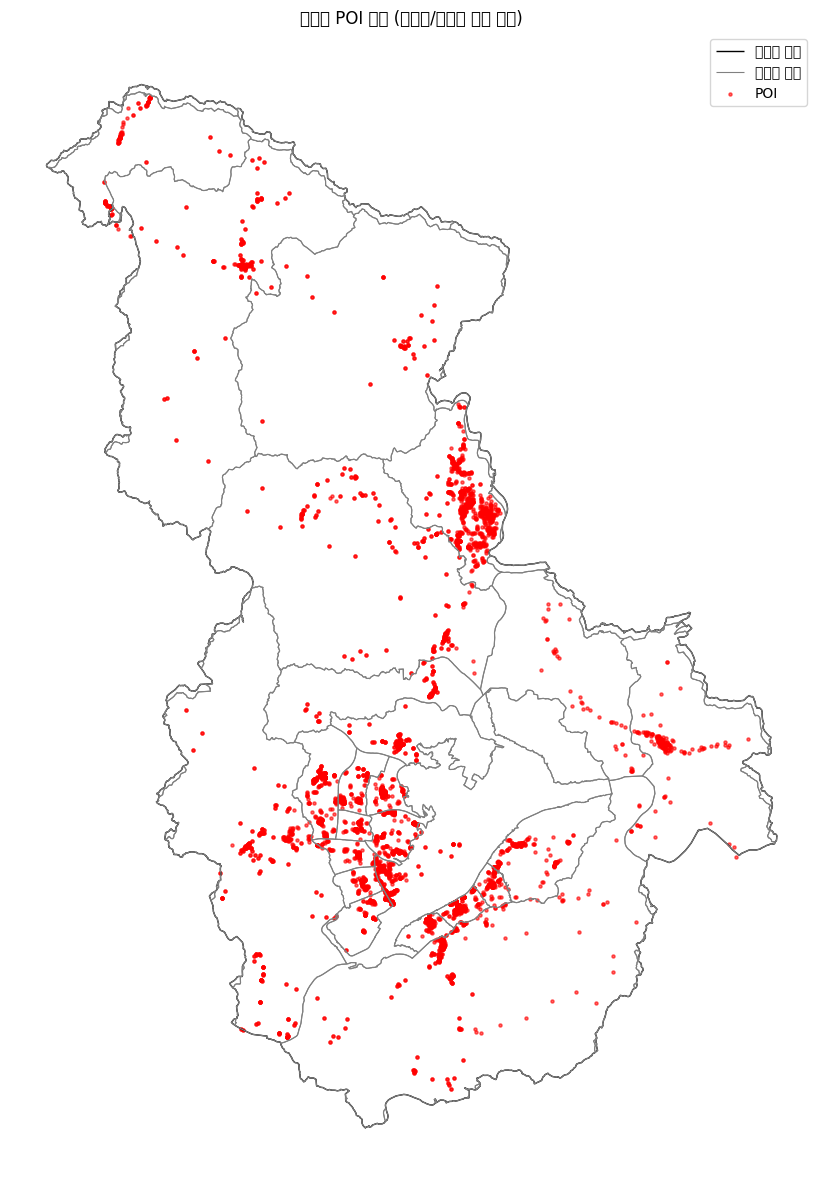

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# 1. 시군구 경계 (세종시) 불러오기
sgg_path = "LARD_ADM_SECT_SGG_세종\LARD_ADM_SECT_SGG_36_202504.shp"
gdf_sgg = gpd.read_file(sgg_path, encoding="euc-kr").explode(index_parts=False)
sejong = gdf_sgg[gdf_sgg["SGG_NM"].str.contains("세종")].to_crs(epsg=5181)

# 2. 행정동 경계 불러오기 + 세종시만 clip
dong_path = "BND_ADM_DONG_PG\BND_ADM_DONG_PG.shp"
gdf_dong = gpd.read_file(dong_path, encoding="euc-kr").to_crs(epsg=5181)
dong_sejong = gpd.clip(gdf_dong, sejong)

# 3. POI 데이터 불러오기 (x, y 좌표 포함)
df_poi = pd.read_csv("sejong_poi_recovered.csv")
geometry = [Point(xy) for xy in zip(df_poi['x'], df_poi['y'])]
gdf_poi = gpd.GeoDataFrame(df_poi, geometry=geometry, crs="EPSG:4326").to_crs(epsg=5181)

# 4. 시각화
fig, ax = plt.subplots(figsize=(12, 12))
sejong.boundary.plot(ax=ax, color="black", linewidth=1, label="세종시 경계")
dong_sejong.boundary.plot(ax=ax, color="gray", linewidth=0.8, label="행정동 경계")
gdf_poi.plot(ax=ax, color="red", markersize=5, alpha=0.6, label="POI")

ax.set_title("세종시 POI 분포 (세종시/행정동 경계 포함)")
ax.axis("off")
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from sklearn.neighbors import KernelDensity

# ▶ 1. POI 데이터 불러오기 및 좌표계 변환
df_poi = pd.read_csv("output\공공데이터_POI_이름좌표완전중복제거.csv")
gdf_poi = gpd.GeoDataFrame(
    df_poi,
    geometry=gpd.points_from_xy(df_poi['x'], df_poi['y']),
    crs="EPSG:4326"
).to_crs(epsg=5181)

# ▶ 2. 어울링 대여소 데이터 불러오기
df_bike = pd.read_csv("data/세종도시교통공사_공공자전거(어울링)_대여소현황_20250106.csv", encoding="euc-kr")

# 위도/경도 컬럼 자동 인식 (일반적으로 lat, lon 또는 위도, 경도)
lon_col = [col for col in df_bike.columns if 'lon' in col.lower() or '경도' in col][0]
lat_col = [col for col in df_bike.columns if 'lat' in col.lower() or '위도' in col][0]

gdf_bike = gpd.GeoDataFrame(
    df_bike,
    geometry=gpd.points_from_xy(df_bike[lon_col], df_bike[lat_col]),
    crs="EPSG:4326"
).to_crs(epsg=5181)

# ▶ 3. KDE 학습 (Epanechnikov 커널, 대역폭 1km)

# ▶ 3. KDE 학습 준비: 좌표 정제
coords = np.vstack([gdf_poi.geometry.x, gdf_poi.geometry.y]).T
coords = coords[~np.isnan(coords).any(axis=1)]  # NaN 제거
coords = coords[np.all(np.isfinite(coords), axis=1)]  # inf 제거

# KDE 학습
kde = KernelDensity(kernel='epanechnikov', bandwidth=1000).fit(coords)

# ▶ 4. 대여소 위치에 대한 KDE score 계산
bike_coords = np.vstack([gdf_bike.geometry.x, gdf_bike.geometry.y]).T
scores = np.exp(kde.score_samples(bike_coords))  # log density → 밀도

# ▶ 5. 밀도 컬럼 추가 및 저장
gdf_bike["kde_density"] = scores
gdf_bike.drop(columns="geometry").to_csv("result/어울링_대여소_with_kde.csv", index=False, encoding="utf-8-sig")

In [ ]:
# ▶ 3. KDE 학습 준비: 좌표 정제
coords = np.vstack([gdf_poi.geometry.x, gdf_poi.geometry.y]).T
coords = coords[~np.isnan(coords).any(axis=1)]  # NaN 제거
coords = coords[np.all(np.isfinite(coords), axis=1)]  # inf 제거

# KDE 학습
kde = KernelDensity(kernel='epanechnikov', bandwidth=1000).fit(coords)
